In [59]:
import os
HOME = os.getcwd()
print(HOME)

/content/segment-anything-2/GroundingDINO


In [60]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

/content/segment-anything-2/GroundingDINO
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [61]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [62]:
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content/segment-anything-2/GroundingDINO/GroundingDINO
  Preparing metadata (setup.py) ... done
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> See above for output.
    
    note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× python setup.py develop did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [63]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/segment-anything-2/GroundingDINO/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [64]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/segment-anything-2/GroundingDINO
/content/segment-anything-2/GroundingDINO/weights


In [65]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/segment-anything-2/GroundingDINO/weights/groundingdino_swint_ogc.pth ; exist: True


In [66]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/segment-anything-2/GroundingDINO/GroundingDINO
final text_encoder_type: bert-base-uncased


In [67]:
from google.colab import files
import cv2

# --- Upload image ---
uploaded = files.upload()
image_path = list(uploaded.keys())[0]   # take the first uploaded file
image_bgr = cv2.imread(image_path)

Saving puppy-1047521_1280.jpg to puppy-1047521_1280.jpg


In [68]:
TEXT_PROMPT = input("Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): ")

Enter your text prompt (e.g., 'a cat', 'a person', 'a car'): dog


In [69]:
import supervision as sv

BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(image_path)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

NotImplementedError: "ms_deform_attn_forward_cuda" not implemented for 'BFloat16'

In [12]:
%cd ..

/content


In [13]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [14]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00


In [15]:
!mkdir -p {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [16]:
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [17]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

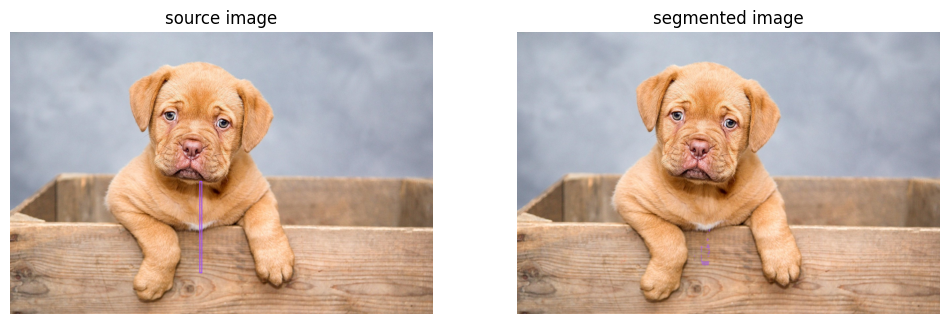

In [44]:
import numpy as np
import matplotlib.pyplot as plt

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# --- Run SAM2 segmentation ---
predictor.set_image(image_rgb)

H, W, _ = image_rgb.shape
# convert boxes to pixels
boxes_xyxy = boxes * torch.tensor([W, H, W, H])
boxes_xyxy = boxes_xyxy.cpu().numpy().astype(int)

predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes_xyxy,
    multimask_output=False
)

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=boxes_xyxy,
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)